In [12]:
import time
import json
import jieba
import jieba.analyse
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from wordcloud import WordCloud, STOPWORDS
from wordcloud import ImageColorGenerator
url = "https://www.cupoy.com/newsfeed/topstory"
browser = webdriver.Chrome()
SCROLL_PAUSE_TIME = 1
news_dict = {}

In [13]:
def get_title():
    #取得文章的標題和連結，並存入news_dict
    global news_dict
    html = browser.page_source
    soup = BeautifulSoup(html, "lxml")
    all_news = soup.find_all("div", attrs={'class':'sc-eEieub sc-iuDHTM ibJqYc'})
    for news in all_news:
        title = news.a["title"]
        news_url = news.a["href"]
        news_dict[str(title)]= str(news_url)

In [14]:
browser.get(url) 
time.sleep(3)
while True:
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = browser.execute_script("return document.body.scrollHeight")
    get_title()
    l = len(news_dict)
    #部分新聞無法取得完整文章內容，故設定redundant，以期待結果數量符合預期
    if l >= 700:
        break

In [15]:
import pandas as pd
pd.DataFrame(list(news_dict))

,0
0,「發抖」的英文怎麼說？ | 經理人
1,每日一句學管理 | 經理人
2,心理學家的職場觀察：公司裡的 4 種人，最累的是這種 | 經理人
3,以VR模擬器進行心理治療的Oxford VR獲得1千萬英鎊融資 | iThome
4,美國國稅局呼籲線上報稅民眾啟用多因素認證 | iThome
...,...
697,其實男生也有內心戲！13個小徵兆透露出他喜歡妳到連自己都害怕的地步！｜PopDaily 發現...
698,荷甲》球星出口加工廠 阿賈克斯賣人發大財 - 最新體育新聞，即時比分，賽程和戰績 | FOX體育臺
699,受武漢肺炎所累 Sony 工程師無法來臺，臺灣 Sony Walkman 四十周年特展以靜態...
700,UBA》公開女生組第一級 前6強複賽轉播賽程表 - 最新體育新聞，即時比分，賽程和戰績 | ...


In [16]:
def getContent(link_url):
    #取得文章內容
    article = ""
    resp = requests.get(link_url)
    resp.encoding = 'utf-8'
    soup = BeautifulSoup(resp.text, 'lxml')
    news_content = soup.find_all("p")
    for p in news_content:
        if ((p.string) is not None):
            article += p.string
    return article

In [17]:
news_content = {}
for title, news_url in news_dict.items():
    try:
        content = getContent(news_url)
        #若文章長度過短，代表未順利取得完整內容，則不將其存入
        if len(content) < 200:
            continue
        news_content[title] = content
    except:
        pass

In [18]:
import json
with open('news.json', 'w', encoding="utf-8") as json_file:
        json.dump(news_content, json_file, indent=4, ensure_ascii=False)

In [26]:
import jieba
import jieba.analyse
jieba.set_dictionary('./dict.txt.big')
dic = {}
content = ""

with open('news.json', 'r') as json_file:
    dic = json.load(json_file)

for title, article in dic.items():
    content += title + article

with open('content.txt', 'w') as f:
    f.write(content)

jieba.analyse.set_stop_words("stop_words.txt")
tags = jieba.analyse.extract_tags(content, 100)
print(" ".join(tags))

Building prefix dict from /Users/oliver/Desktop/Github/1st-PyCrawlerMarathon/CUPOY/dict.txt.big ...
Loading model from cache /var/folders/wp/hqrj4fw972s76k6mt5blv4yh0000gn/T/jieba.u3e02e943719603cd9f9548568d8d74ac.cache
Loading model cost 1.696 seconds.
Prefix dict has been built successfully.
中國 台灣 武漢 疫情 肺炎 美國 新冠 口罩 國家 防疫 發現 經濟 服務 媽媽 可能 孩子 發生 未來 企業 發展 病毒 隔離 網路 系統 技術 電影 過去 機會 處理 冠狀病毒 持續 產品 情況 確診 市場 手機 復工 超過 資訊 決定 使用 醫院 內容 設計 工作 報導 歷史 產業 風評 需要 員工 日本 關係 感染 建議 之間 學習 當時 評論 風險 特別 人類 嚴重 醫療 治療 人們 媒體 專家 進入 面對 根據 團隊 科技 狀況 討論 投資 對方 成長 生產 導致 課程 生活 改變 網站 提供 衝擊 協助 分享 觀點 政府 帶來 資料 國際 目前 閱讀 或許 軟體 地區 經驗 熱門


In [27]:
table = []
dic = {}
for tag in tags:
    dic[tag]=content.count(tag)
    table.append({"Word":tag, "Count":content.count(tag)})
table.sort(key=lambda x:x["Count"], reverse = True)

In [21]:
import pandas as pd
pd.DataFrame(table)
# table = pd.Series(table)
# table.to_frame()


,Word,Count
0,中國,930
1,台灣,789
2,可能,697
3,疫情,684
4,肺炎,614
...,...,...
95,帶來,113
96,172020,112
97,閱讀,112
98,或許,111


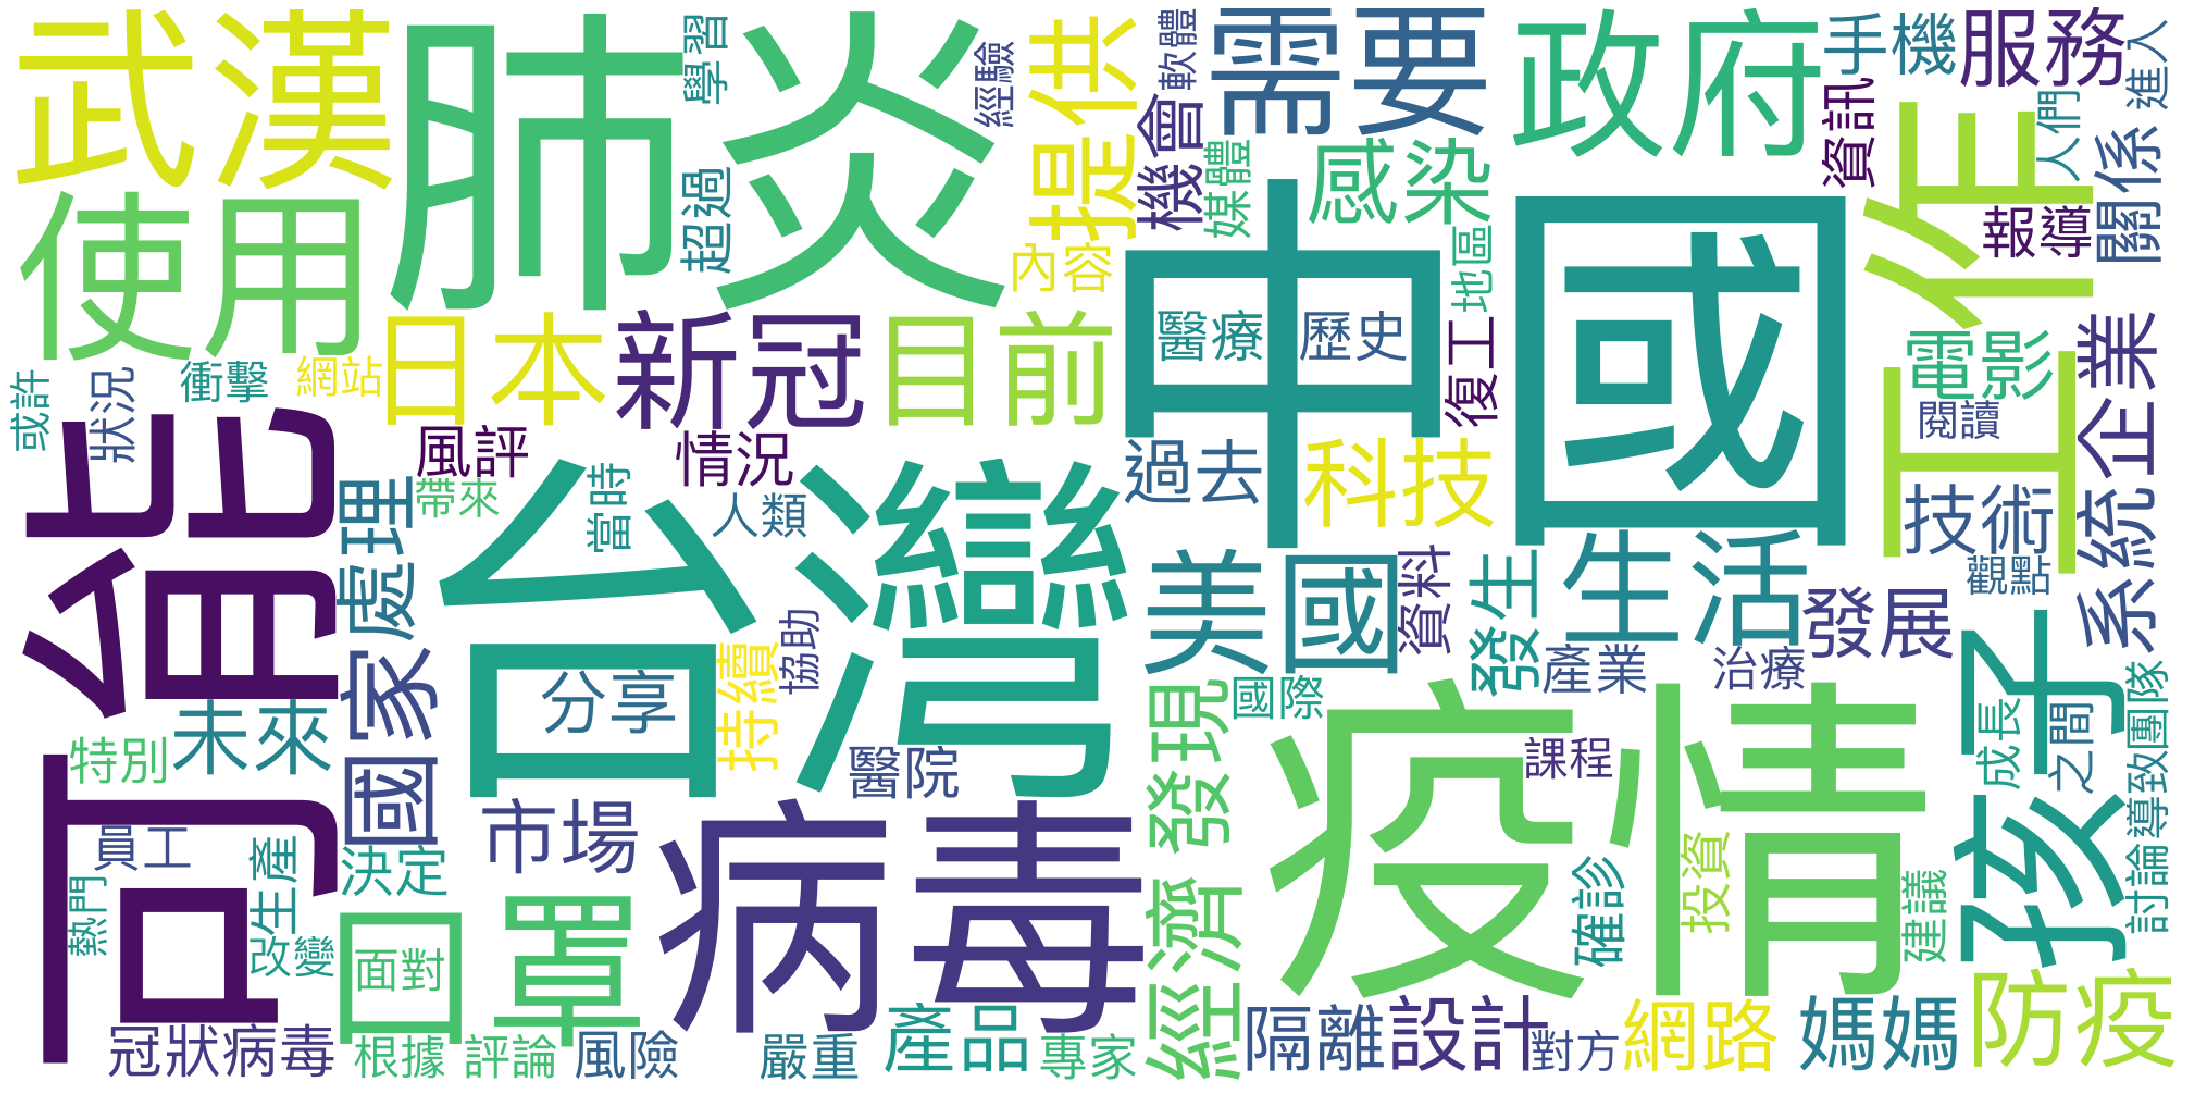

In [28]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
font = "PingFang.ttc"
wc = WordCloud(background_color='white',font_path=font, width=2000, height=1000)
wc.generate_from_frequencies(dic)
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))
plt.imshow(wc)
plt.axis("off")
plt.show()